<a href="https://colab.research.google.com/github/Achsah1/Histogram/blob/main/HistogramMatching%26DeepEmbedding_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [17]:
class EmbModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )

    def forward(self, x):
        return self.net(x)


In [18]:
class DiffHistogramLoss(nn.Module):
    def __init__(self, bins=20, sigma=0.1):
        super().__init__()
        self.bins = bins
        self.sigma = sigma
        self.bin_centers = nn.Parameter(torch.linspace(-1, 1, bins), requires_grad=False)

    def _smooth_hist(self, x):
        # x : (N,)
        x = x.to(self.bin_centers.device)   # <--- FIX HERE
        diff = x.unsqueeze(1) - self.bin_centers.unsqueeze(0)
        weights = torch.exp(-(diff**2) / (2 * self.sigma**2))
        return weights.mean(0)

    def forward(self, emb, labels):
        emb = F.normalize(emb, dim=1)

        sim = emb @ emb.t()        # cosine similarity
        labels = labels.unsqueeze(1)

        pos = sim[(labels == labels.t()) & ~torch.eye(len(labels)).bool().to(device)]
        neg = sim[(labels != labels.t())]

        pos_hist = self._smooth_hist(pos)
        neg_hist = self._smooth_hist(neg)

        cdf_pos = torch.cumsum(pos_hist, dim=0)

        loss = torch.sum(neg_hist * cdf_pos)
        return loss


In [19]:
def get_embedding_dataset(N=500):
    X = torch.randn(N, 64)
    y = torch.randint(0, 5, (N,))
    return X.to(device), y.to(device)


In [20]:
def train_histogram_loss(epochs=5, batch=32):
    model = EmbModel().to(device)
    crit = DiffHistogramLoss().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    X, y = get_embedding_dataset()
    data = DataLoader(TensorDataset(X,y), batch_size=batch, shuffle=True)

    losses = []

    for ep in range(epochs):
        for batch_x, batch_y in data:
            emb = model(batch_x)
            loss = crit(emb, batch_y)

            opt.zero_grad()
            loss.backward()
            opt.step()

        losses.append(loss.item())
        print(f"Epoch {ep+1}/{epochs} | Loss: {loss.item():.4f}")

    return model, losses


In [21]:
class WeatherModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3)   # sunny / cloudy / rain
        )

    def forward(self, x):
        return self.net(x)


In [22]:
def get_weather_dataset(N=500):
    X = torch.randn(N, 64)
    y = torch.randint(0, 3, (N,))
    return X.to(device), y.to(device)

def train_weather(epochs=5, batch=32):
    model = WeatherModel().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()

    X, y = get_weather_dataset()
    data = DataLoader(TensorDataset(X,y), batch_size=batch, shuffle=True)

    accs = []

    for ep in range(epochs):
        for batch_x, batch_y in data:
            out = model(batch_x)
            loss = crit(out, batch_y)

            opt.zero_grad()
            loss.backward()
            opt.step()

        # accuracy approx
        pred = model(X).argmax(1)
        acc = (pred == y).float().mean().item()
        accs.append(acc)
        print(f"Epoch {ep+1}/{epochs} | Accuracy: {acc:.3f}")

    return model, accs


Epoch 1/5 | Loss: 3.5139
Epoch 2/5 | Loss: 3.4156
Epoch 3/5 | Loss: 3.4101
Epoch 4/5 | Loss: 2.9951
Epoch 5/5 | Loss: 3.4308
Epoch 1/5 | Accuracy: 0.420
Epoch 2/5 | Accuracy: 0.460
Epoch 3/5 | Accuracy: 0.532
Epoch 4/5 | Accuracy: 0.572
Epoch 5/5 | Accuracy: 0.596


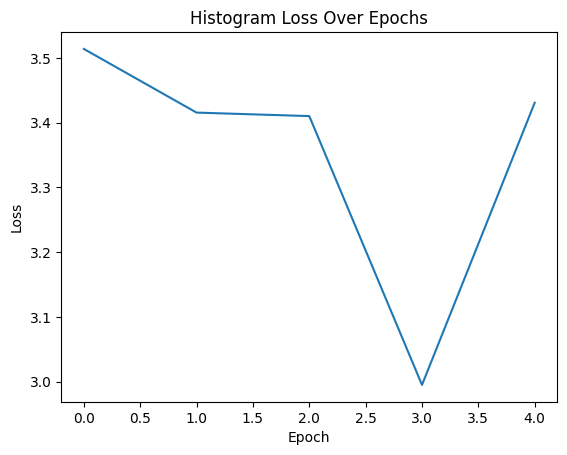

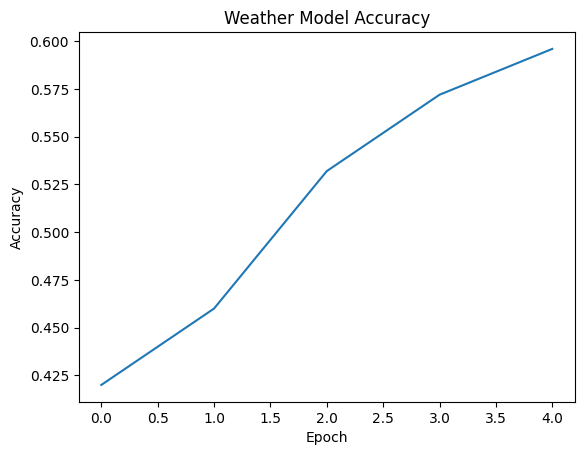

In [23]:
emb_model, emb_losses = train_histogram_loss()
weather_model, weather_accs = train_weather()

plt.plot(emb_losses)
plt.title("Histogram Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(weather_accs)
plt.title("Weather Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
